# BWA

In [17]:
import pysam
import matplotlib.pyplot as plt
%matplotlib inline
from Bio import SeqIO
import pandas as pd
import math 

Покрытие генома (график, процент покрытого генома, среднее покрытие)

In [4]:
def updateCover(record, cover):
    if not record.is_unmapped:
            rpos = record.reference_start
            rlen = record.reference_length
            cover[rpos] += 1
            cover[rpos + rlen] -= 1

In [5]:
def showCover(cover):
    print("Average coverage: " + str(sum(cover)/len(cover)))
    print("Coverage rate: " + str((len(cover) - cover.count(0))/len(cover)))
    avcover = [0]*(len(cover)//1000 + 1)
    x = [i for i in range(0, len(cover), 1000)]
    for i in range(len(cover)):
        avcover[i//1000] += cover[i]
    for i in range(len(avcover) - 1):
        avcover[i] /= 1000
    avcover = avcover[:-1]
    x = x[:len(avcover)]
    
    plt.plot(x, avcover)
    plt.axis([0, (len(cover)//1000 - 1)*1000, 0, max(avcover)])
    plt.xlabel('coord')
    plt.ylabel('Coverage')
    plt.show()

Статистика длин инделов.

In [28]:
def updateInDelLen(record, indelLensHist):
    if record.is_unmapped:
            return
    cigar = record.cigartuples
    for i in range(len(cigar)):
            if (cigar[i][0] == 1): 
                if (cigar[i][1] + 10 < 20):
                    indelLensHist[10 + cigar[i][1]] += 1
            if (cigar[i][0] == 2):
                if (10 - cigar[i][1] >= 0):
                    indelLensHist[10 - cigar[i][1]] += 1
                

Статистика длин инделов в завимости от длины гомополимерного участка (участок состоящий из одного типа нуклеотидов, например АААААААА). Мы фиксируем длину гомополимерного участка (пусть 5bp), и находим все гомополимеры такой длины в референсе. Дальше смотрим как участки этой длины прочитались секвенатором. Смотрим сколько раз прочиталось 3bp, 4bp, 5bp, 6bp и итд. Повторяем это для гомополимеров всех длин (например, от 3 до 20).


In [7]:
def calculateRefHomopol(ref, refHom):
    afterCnt = [1]*len(ref)
    for i in range(1, len(ref)):
        if (ref[i] == ref[i - 1]):
            refHom[i] = refHom[i - 1] + 1
    for i in range(len(ref) - 2, 0, -1):
        if (ref[i + 1] == ref[i]):
            afterCnt[i] += afterCnt[i + 1]
    for i in range(len(ref)):
        refHom[i] += afterCnt[i]

In [8]:
def updateInDelHomopol(record, ref, refHom, inDelHomLenHist):
    if record.is_unmapped:
        return
    cigar = record.cigartuples
    rpos = record.reference_start
    seq = record.query_sequence
    seqHom = [0]*len(seq)
    calculateRefHomopol(seq, seqHom)
    spos = 0
    mxSeqHom = 1
    
    for i in range(len(cigar)):
        if (cigar[i][0] == 0 or cigar[i][0] == 7 or cigar[i][0] == 8):
            cntl = cigar[i][1]
            for j in range(cntl):
                if (ref[rpos + j - 1] != ref[rpos + j]):
                    if (refHom[rpos + j - 1] < 20 and mxSeqHom < 20):
                        inDelHomLenHist[refHom[rpos + j - 1]][mxSeqHom] += 1
                    mxSeqHom = 0
                mxSeqHom = max(mxSeqHom, seqHom[spos + j])
            rpos += cigar[i][1]
            spos += cigar[i][1]
        elif (cigar[i][0] == 1 or cigar[i][0] == 4):
            spos += cigar[i][1]
        elif (cigar[i][0] == 2 or cigar[i][0] == 3):
            cntl = cigar[i][1]
            for j in range(cntl):
                if (ref[rpos + j - 1] != ref[rpos + j]):
                    if (refHom[rpos + j - 1] < 20 and mxSeqHom < 20):
                        inDelHomLenHist[refHom[rpos + j - 1]][mxSeqHom] += 1
                    mxSeqHom = 0
            rpos += cigar[i][1]
    if (refHom[rpos - 1] < 20 and mxSeqHom < 20):
        inDelHomLenHist[refHom[rpos - 1]][mxSeqHom] += 1
                

Статистика качества нуклеотидов при ошибочно вставленном нуклеотиде

In [9]:
def updateQualityInsert(alig_record, read_record, qualityInsertStatistic):
    if alig_record.is_unmapped:
            return
    readpos = 0
    cigar = alig_record.cigartuples
    for i in range(len(cigar)):
        if (cigar[i][0] == 0 or cigar[i][0] == 7 or cigar[i][0] == 8):
            readpos += cigar[i][1]
        elif (cigar[i][0] == 1 or cigar[i][0] == 4):
            for j in range(cigar[i][1]):
                qualityInsertStatistic[read_record.letter_annotations["phred_quality"][readpos + j]] += 1
            readpos += cigar[i][1]
    

Статистика качества нуклеотидов при замене


In [10]:
def updateQualityMis(alig_record, read_record, ref, qualityMisStatistic):
    if alig_record.is_unmapped:
            return
    readpos = 0
    cigar = alig_record.cigartuples
    rpos = alig_record.reference_start
    seq = alig_record.query_sequence
    for i in range(len(cigar)):
        if (cigar[i][0] == 0 or cigar[i][0] == 8 or cigar[i][0] == 7):
            cntl = cigar[i][1]
            for j in range(cntl):
                if (seq[readpos + j] != ref[rpos + j]):
                    qualityMisStatistic[read_record.letter_annotations["phred_quality"][readpos + j]] += 1
            readpos += cigar[i][1]
            rpos += cigar[i][1]
        elif (cigar[i][0] == 1 or cigar[i][0] == 4):
            readpos += cigar[i][1]
        elif (cigar[i][0] == 2 or cigar[i][0] == 3):
            rpos += cigar[i][1] 

Таблица частот замен/вставок/удалений

In [11]:
def getLetId(c, isrv):
    #print(c)
    let = ["ACGTN", "TGCAN"]
    for i in range(5):
        if (let[isrv][i] == c):
            return i

def updateReplaceMatrix(record, ref, rmat):
        let = "ACGTN"
        if record.is_unmapped:
            return
        
        cigar = record.cigartuples
        rpos = record.reference_start
        seq = record.query_sequence
        spos = 0
        for i in range(len(cigar)):
            if (cigar[i][0] == 0 or cigar[i][0] == 7 or cigar[i][0] == 8):
                cntl = cigar[i][1]
                isrv = 0#record.is_reverse
                for j in range(cntl):
                    rmat[getLetId(seq[spos + j], isrv)][getLetId(ref[rpos + j], 0)] += 1
                rpos += cigar[i][1]
                spos += cigar[i][1]
            elif (cigar[i][0] == 1 or cigar[i][0] == 4):
                cntl = cigar[i][1]
                for j in range(cntl):
                    rmat[getLetId(seq[spos + j], 0)][4] += 1
                spos += cigar[i][1]
            elif (cigar[i][0] == 2 or cigar[i][0] == 3):
                cntl = cigar[i][1]
                for j in range(cntl):
                    rmat[4][getLetId(ref[rpos + j], 0)] += 1
                rpos += cigar[i][1]

def drawMatrix(matrix):
    df = pd.DataFrame(data=matrix, columns=['A', 'C', 'G', 'T', 'N'], index=['A', 'C', 'G', 'T', 'N'])
    print(df)

Подсчет статистик для ридов

In [29]:
def calculateStatistic(filename, reffilename, readsfilename):
    for rec in SeqIO.parse(reffilename, "fasta"): 
        ref = rec.seq 
    
    record_dict = SeqIO.to_dict(SeqIO.parse(readsfilename, "fastq"))
    
    samfile = pysam.AlignmentFile(filename, "r")
    reflen = samfile.header.get("SQ")[0]['LN']
    
    cover = [0]*(reflen + 1)
    replaceMatrix = [[0]*5 for i in range(5)]
    inDelHomLenHist = [[0]*20 for i in range(20)]
    indelLensHist = [0]*20
    qualityInsertStatistic = [0]*66
    qualityMisStatistic = [0]*66
    refHom = [0]*len(ref)
    calculateRefHomopol(ref, refHom)
    
    for record in samfile.fetch():
        updateCover(record, cover)
        updateReplaceMatrix(record, ref, replaceMatrix)
        updateInDelLen(record, indelLensHist)
        updateQualityInsert(record, record_dict[record.query_name], qualityInsertStatistic)
        updateQualityMis(record, record_dict[record.query_name], ref, qualityMisStatistic)
        updateInDelHomopol(record, ref, refHom, inDelHomLenHist)
        
    for i in range(1, reflen):
        cover[i] += cover[i - 1]
    return cover, replaceMatrix, indelLensHist, qualityInsertStatistic, qualityMisStatistic, inDelHomLenHist

In [13]:
def showStatistic(hist, xlabel, ylabel):
    xs = [i for i in range(0, len(hist))]
    
    plt.plot(xs, hist, 'bo')
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.show() 

## 1.  BWA

In [14]:
! bwa index /Johnny/students/NGS/data/5/DH10B-K12.fasta -p ./DH10B-K12

[bwa_index] Pack FASTA... 0.11 sec
[bwa_index] Construct BWT for the packed sequence...
[bwa_index] 3.55 seconds elapse.
[bwa_index] Update BWT... 0.04 sec
[bwa_index] Pack forward-only FASTA... 0.05 sec
[bwa_index] Construct SA from BWT and Occ... 1.26 sec
[main] Version: 0.7.15-r1140
[main] CMD: bwa index -p ./DH10B-K12 /Johnny/students/NGS/data/5/DH10B-K12.fasta
[main] Real time: 6.766 sec; CPU: 5.020 sec


In [16]:
! bwa mem DH10B-K12 /Johnny/students/NGS/data/5/B22-730.fastq > bwa_B22-730.sam

[M::bwa_idx_load_from_disk] read 0 ALT contigs
[M::process] read 30580 sequences (10000589 bp)...
[M::process] read 30700 sequences (10000499 bp)...
[M::mem_process_seqs] Processed 30580 reads in 13.596 CPU sec, 13.562 real sec
[M::process] read 30654 sequences (10000464 bp)...
[M::mem_process_seqs] Processed 30700 reads in 14.908 CPU sec, 14.768 real sec
[M::process] read 30558 sequences (10000069 bp)...
[M::mem_process_seqs] Processed 30654 reads in 15.584 CPU sec, 15.406 real sec
[M::process] read 30468 sequences (10000148 bp)...
[M::mem_process_seqs] Processed 30558 reads in 12.048 CPU sec, 11.885 real sec
[M::process] read 30596 sequences (10000413 bp)...
[M::mem_process_seqs] Processed 30468 reads in 12.620 CPU sec, 12.468 real sec
[M::process] read 30514 sequences (10000381 bp)...
[M::mem_process_seqs] Processed 30596 reads in 13.904 CPU sec, 13.841 real sec
[M::process] read 30520 sequences (10000266 bp)...
[M::mem_process_seqs] Processed 30514 reads in 12.356 CPU sec, 12.231 r

In [30]:
cover, replaceMatrix, indelLensHist, qualityInsertStatistic, qualityMisStatistic, inDelHomLenHist = calculateStatistic("bwa_B22-730.sam", "/Johnny/students/NGS/data/5/DH10B-K12.fasta", "/Johnny/students/NGS/data/5/B22-730.fastq")

In [32]:
from math import *

print(indelLensHist)
for i in range(0, len(indelLensHist)):
    if (indelLensHist[i] > 0):
        indelLensHist[i] = log2(indelLensHist[i])

[0, 0, 3, 10, 23, 76, 277, 1403, 18865, 340196, 0, 449394, 28183, 2948, 837, 328, 203, 124, 91, 54]


#### Покрытие генома

Average coverage: 34.034596505694026
Coverage rate: 0.9998798584249973


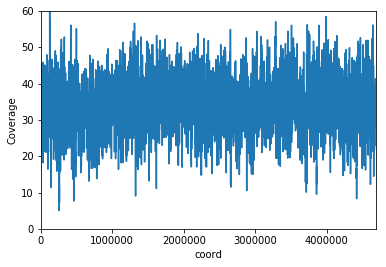

In [22]:
showCover(cover)

#### Таблица частот замен/вставок/удалений

In [35]:
drawMatrix(replaceMatrix)

          A         C         G         T       N
A  40038583     10360     17215     11325  590244
C      9147  39493809      7209     24493  442044
G     23657      8092  39405410      9060  440955
T     11173     16671     10563  40010171  591824
N    119254     72479     72804    119372       0


#### Статистика длин инделов

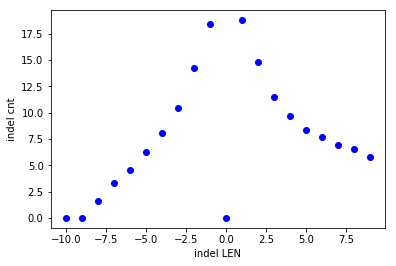

In [33]:
xs = [i for i in range(-10, 10)]
    
plt.plot(xs, indelLensHist, 'bo')
plt.xlabel('indel LEN')
plt.ylabel('indel cnt')
plt.show() 

#### Статистика качества нуклеотидов при ошибки вставке нуклеотидов. 

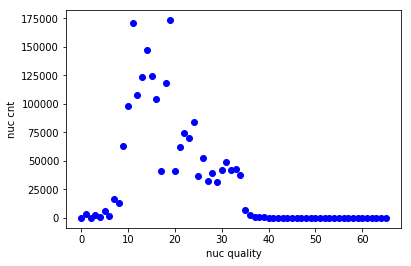

In [25]:
showStatistic(qualityInsertStatistic, 'nuc quality', 'nuc cnt')

#### Статистика качества нуклеотидов при ошибке замены. 

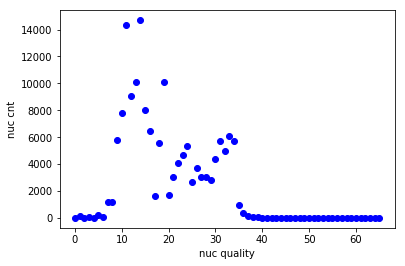

In [36]:
showStatistic(qualityMisStatistic, 'nuc quality', 'nuc cnt')

#### Статистика длин инделов в зависимости от длины гомополимерного участка. Строчки --- длина гомополимерного участка в референсе, столбцы --- в ридах. 

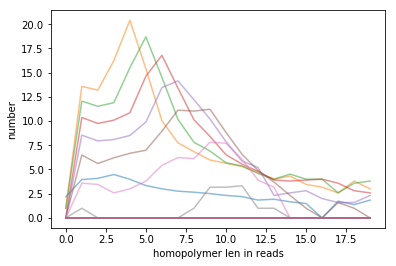

In [36]:
for i in range(3, 20):
    xs = [i for i in range(0, 20)]
    for j in range(len(inDelHomLenHist[i])):
        if (inDelHomLenHist[i][j] != 0):
            inDelHomLenHist[i][j] = log2(inDelHomLenHist[i][j])
    plt.plot(xs, inDelHomLenHist[i], alpha = 0.5)

plt.xlabel("homopolymer len in reads")
plt.ylabel("number")
plt.show()

#df = pd.DataFrame(data=inDelHomLenHist, columns=[i for i in range(0, 20)], index=[i for i in range(0, 20)])
#print(df)

## 2. Bowtie2 

In [ ]:
! bowtie2-build /Johnny/students/NGS/data/5/DH10B-K12.fasta dh10b

In [38]:
! bowtie2 -x dh10b -U /Johnny/students/NGS/data/5/B22-730.fastq > bowtie2_B22-730.sam

494921 reads; of these:
  494921 (100.00%) were unpaired; of these:
    10992 (2.22%) aligned 0 times
    448286 (90.58%) aligned exactly 1 time
    35643 (7.20%) aligned >1 times
97.78% overall alignment rate


In [39]:
cover, replaceMatrix, indelLensHist, qualityInsertStatistic, qualityMisStatistic, inDelHomLenHist = calculateStatistic("bowtie2_B22-730.sam", "/Johnny/students/NGS/data/5/DH10B-K12.fasta", "/Johnny/students/NGS/data/5/B22-730.fastq")

#### Покрытие генома

Average coverage: 33.9770160417811
Coverage rate: 0.9997661187101191


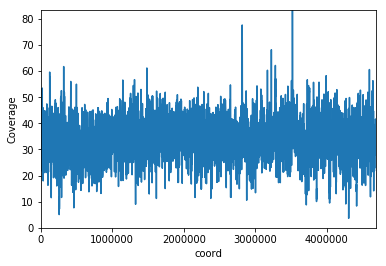

In [40]:
showCover(cover)

#### Таблица частот замен/вставок/удалений

In [41]:
drawMatrix(replaceMatrix)

          A         C         G         T       N
A  39880292     43074     48105     42916  201054
C     36684  39355740     36340     51593   93275
G     50841     37395  39229857     36274   92490
T     42630     47025     43806  39854030  202711
N    118517     73464     73634    118773       0


#### Статистика длин инделов

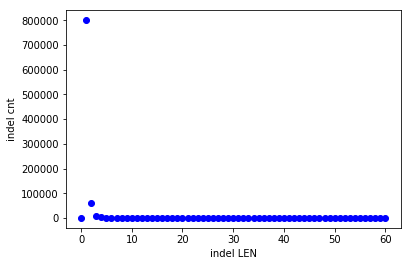

In [42]:
showStatistic(indelLensHist, 'indel LEN', 'indel cnt')

#### Статистика качества нуклеотидов при ошибки вставке нуклеотидов. 

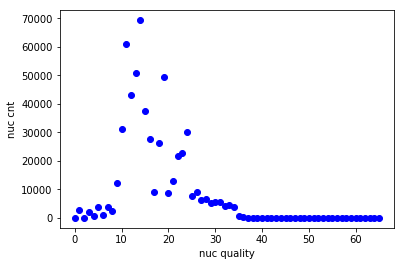

In [43]:
showStatistic(qualityInsertStatistic, 'nuc quality', 'nuc cnt')

#### Статистика качества нуклеотидов при ошибке замены. 

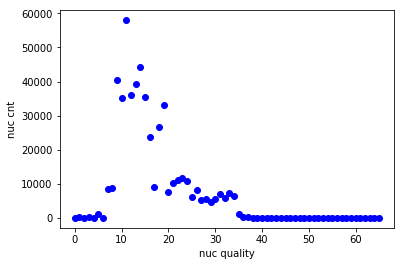

In [44]:
showStatistic(qualityMisStatistic, 'nuc quality', 'nuc cnt')

Качество у невыравненных или удаленных/вставленных нуклеотидов во данном случае выглядит ниже. 

#### Статистика длин инделов в зависимости от длины гомополимерного участка. Строчки --- длина гомополимерного участка в референсе, столбцы --- в ридах. 

In [45]:
df = pd.DataFrame(data=inDelHomLenHist, columns=[i for i in range(0, 20)], index=[i for i in range(0, 20)])
print(df)

       0         1         2        3        4       5       6      7     8   \
0       0         0         0        0        0       0       0      0     0   
1   55497  85978756    248063    35949    13607    5843    2841   1293   770   
2     924    381207  22836801    97258     4853    1782     771    315   186   
3      39     53684    136506  5446279    61592    1547     403    151   118   
4       0     13570     10566    80743  1384770   43298    1114    238   128   
5       2      4792      3212     4222    46806  423435   23453   1158   257   
6       0      1503       950     1182     2015   25443  112606  10851  1120   
7       0       408       285      296      395     991   11126  18047  4685   
8       0       100        57       84      102     136     506   2221  2133   
9       0        13        11        8        8      14      42     75    78   
10      0         2         0        1        1       0       0      1     2   
11      0         0         0        0  

Глобально, при использование bowtie2 конечно видно, что результаты не такие как у bwa, но при этом они примерно такие же. Каких-то резких радикальных отличий я не вижу. 

Про длины гомополимеров. Все-таки чаще считывается на один нуклеотид меньше, чем на один больше. На случии со совсем маленькими гомополимерами лучше не смотреть. Там перекос не в ту сторону легко может объясняться например тем, что я при реализации не особо проверяла что в референсе и в риде на одном и том же месте стоит одна и та же аминокислота.  